In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# neccessities for the project setup
# this enables automatic reload of the libraries specific to this project
%load_ext autoreload
%autoreload 1

import os
import sys

# fs_utils.py stores paths to every other directory in the projects
# this module is located at the top level of the repository
# jupyter can't see it unless I change the cwd manually
# official man page tells that it's not actually possible in any other way
sys.path.append(os.path.abspath(".."))
%aimport fs_utils

# extend != append, the former appends the content while 
# the latter — the list with two elements...
os.chdir(fs_utils.ROOT_DIR)
sys.path.extend([fs_utils.LIB_DIR, fs_utils.ROOT_DIR, fs_utils.SRC_DIR])

In [2]:
# standard library
import bisect
import gc
import pickle
import multiprocessing as mp

gc.enable()

In [3]:
# third-party modules
from collections import defaultdict, OrderedDict
from joblib import Parallel, delayed
import igraph as ig
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%aimport matplotlib.font_manager
import numpy as np
import pandas as pd
import psutil
import scipy.stats as sps
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm_notebook

%matplotlib inline

In [4]:
# custom modules
%aimport util
%aimport qtls
%aimport networks
%autosave 15

Autosaving every 15 seconds


In [74]:
qtls_df = {
    "eQTLs_2018" : { 
        "A&B" : pd.read_table("./data/processed/eQTLs/2018/qtls_albert&bloom_from_paper.csv"),
        "limix" : pd.read_table("./data/processed/eQTLs/2018/qtls_limix.csv")
    }, 
}
scaler_df = {
    "eQTLs_2018" : {
        "A&B" : MinMaxScaler()
    }
}
qtls_df["eQTLs_2018"]["A&B"]["score"] = (1 - scaler_df["eQTLs_2018"]["A&B"]\
                                               .fit_transform(
                                                    qtls_df["eQTLs_2018"]["A&B"]["LOD"].values[:,None]
                                                )
                                          )
qtls_df["eQTLs_2018"]["limix"]["score"] = qtls_df["eQTLs_2018"]["limix"]["q_value"]

# Physical and genetic interactions taken from TheBioGrid project
interactome_df = pd.read_table("./data/raw/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[
#     full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association", 
    "colocalization", 
    "direct interaction",
    "physical association"
]

In [6]:
interactome_df.set_index('Interaction Type', inplace=True)

genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

interaction_categories = (genetic_interaction_categories 
                          + physical_interaction_categories 
                          + ["all", "physical", "genetic"])

def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

type2interactome = {}
for edge_type in interaction_categories:
    with open("./data/raw/interactions/{}_interactions_graph.pkl".format(edge_type), "rb") as infile:
        type2interactome[edge_type] = pickle.load(infile)

In [7]:
category = {"all" : "all"}
for edge_type in physical_interaction_categories + ["physical"]:
    category[edge_type] = "physical"
for edge_type in genetic_interaction_categories + ["genetic"]:
    category[edge_type] = "genetic"

# Exploring the hotspot dataset

Albert and Bloom detected 102 eQTL hotspots using an algorithm of their own invention.  

## Legend

- **hotspotMarker** —	Position of the hotspot based on initial scan for hotspots (prior to bootstrapping). This string can be used to cross-reference between this table and the various other hotspot-centric result tables
- **chromosome** —	The chromosome on which the hotspot is located
- **bootstrapPeak** —	Median bootstrap position
- **bootstrapIntervalLeft** —	95% bootstrap confidence interval of hotspot location – left marker
- **bootstrapIntervalRight** —	95% bootstrap confidence interval of hotspot location – right marker
- **boostrapIntervalWidth** —	bootstrapIntervalRight minus bootstrapIntervalLeft
- **numberGenesInHotspot** —	Number of genes that overlap the hotspot location interval
- **numberEQTLInHotspot** —	Number of eQTL with confidence intervals that overlap the hotspot
- **numberNonzeroEffects** —	Number of genes with non-zero effects when fitting hotspot effects

In [8]:
hotspot_df = pd.read_csv("data/raw/eQTLs/2018/hotspots.csv", sep='\t')
hotspot_df.sort_values(by="boostrapIntervalWidth", ascending=False).head()

,hotspotMarker,chromosome,bootstrapPeak,bootstrapIntervalLeft,bootstrapIntervalRight,boostrapIntervalWidth,numberGenesInHotspot,numberEQTLInHotspot,numberNonzeroEffects
28,chrV:183957_A/G,chrV,183957,137820,196986,59166,38,283,438
18,chrIV:461656_A/G,chrIV,452236,414243,464571,50328,34,1020,846
56,chrX:426287_C/A,chrX,429703,416411,455247,38836,24,261,276
22,chrIV:745766_G/A,chrIV,745766,728918,759809,30891,15,810,511
37,chrVII:178509_T/C,chrVII,194505,174975,205155,30180,19,1669,1109


In [9]:
hotspot_df[["boostrapIntervalWidth", "numberGenesInHotspot", "numberEQTLInHotspot"]].describe()

,boostrapIntervalWidth,numberGenesInHotspot,numberEQTLInHotspot
count,102.000000,102.000000,102.000000
mean,10596.519608,7.401961,539.696078
std,11290.767253,6.846637,728.026694
min,0.000000,1.000000,7.000000
25%,2933.500000,3.000000,84.000000
50%,5858.000000,5.000000,272.000000
75%,15682.250000,10.000000,703.000000
max,59166.000000,38.000000,3802.000000


- **Nearly a half of hotspots contain only one gene or no genes at all.**  
- **Hotspots have 540 associated eQTLs on average (with a median value of 272 — right tail of the distribution is heavy).**  
  **79/102 ($\approx 75\%$) of hotspots have less than 387 and only 11 hotspots have more than 766.**
- Not sure about the interval width summary: is a mean value of 10596 large or small?

(array([50., 19., 13., 10.,  5.,  2.,  1.,  0.,  1.,  1.]),
 array([ 1. ,  4.7,  8.4, 12.1, 15.8, 19.5, 23.2, 26.9, 30.6, 34.3, 38. ]),
 <a list of 10 Patch objects>)

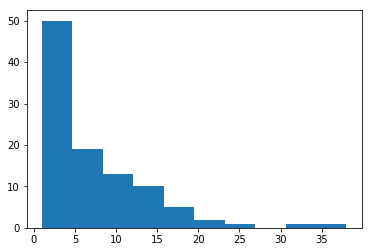

In [10]:
plt.hist(hotspot_df.numberGenesInHotspot)

(array([63., 16., 12.,  3.,  3.,  0.,  1.,  1.,  2.,  1.]),
 array([   7. ,  386.5,  766. , 1145.5, 1525. , 1904.5, 2284. , 2663.5,
        3043. , 3422.5, 3802. ]),
 <a list of 10 Patch objects>)

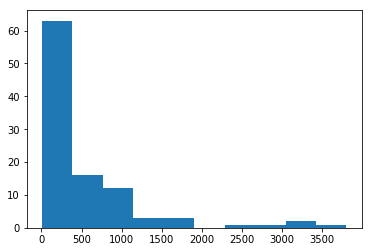

In [11]:
plt.hist(hotspot_df.numberEQTLInHotspot)

In [12]:
qtls_df["eQTLs_2018"]["A&B"].shape

(36498, 14)

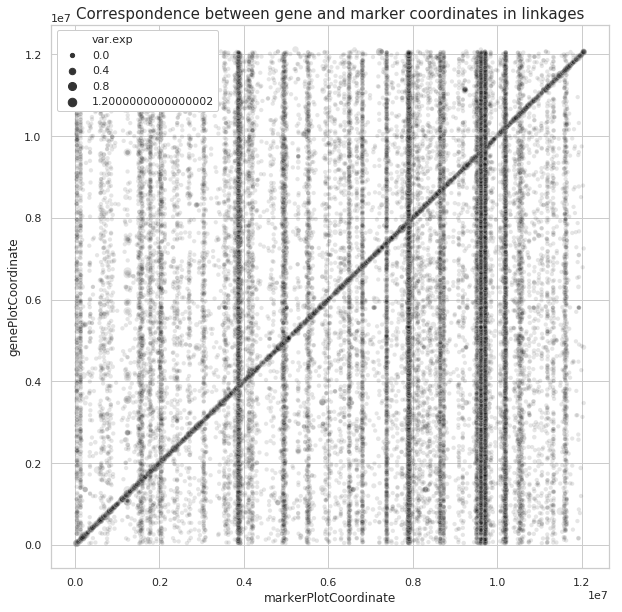

In [137]:
plt.figure(figsize=(10,10))
plt.title("Correspondence between gene and marker coordinates in linkages", fontsize=15)
sns.scatterplot(
    x="markerPlotCoordinate", 
    y="genePlotCoordinate", 
    color="black",
    size="var.exp",
    data=qtls_df["eQTLs_2018"]["A&B"], 
    alpha=0.1
);
plt.legend(framealpha=1.);

In [256]:
class HotspotPlotter:
    def __init__(self, qtl_df, qtl_type, figsize, title):
        sns.set(style="whitegrid")
        self.fig, self.ax = plt.subplots(figsize=figsize)
        self.ax.set_title(
            title,
            fontsize=30
        )        
        self.ax.set_xlabel("genomic coordinates (chromosome numbers)", fontsize=25)
        self.ax.set_ylabel("number of genes influenced", fontsize=25)
        
        self.qtl_df = qtl_df
        self.qtl_type = qtl_type
        
        with open("./data/raw/genomic_features/order_of_markers.pkl", "rb") as pickle_file:
            self.marker2location = pickle.load(pickle_file)
        with open("./data/raw/genomic_features/chromosome_endpoints.pkl","rb") as pickle_file:
            self.chromosome_endpoints = pickle.load(pickle_file)
        self.chromosome_labels = [util.as_roman(n) for n in np.arange(1, 17)]
        
        self.ax.set_xticks(self.chromosome_endpoints)
        self.ax.set_xticklabels(self.chromosome_labels)
        self.ax.tick_params(axis='both', which='major', labelsize=20)
        self.ax.tick_params(axis='both', which='minor', labelsize=20)
        self.ax.grid(linestyle="dotted")
        
        # plt.savefig("img/qtl_distributions/corrected_limix_vs_A&B_2018.png", dpi=300)
#         plt.show()
#         plt.close()
        
    def _base_plot(self):
        for i in range(1, 17):
            self.ax.axvline(
                x=self.chromosome_endpoints[i - 1], 
                linestyle='--', 
                color='grey', 
                alpha=0.8
            )
            
        QTL_markers, self.QTL_y = qtls.linkages2gencoords(self.qtl_df)
        self.QTL_x = [self.marker2location[m] for m in QTL_markers]
        print(QTL_markers[np.argsort(self.QTL_y)[::-1][:10]])
        
        self.ax.plot(
            self.QTL_x,
            self.QTL_y,
            label="{}, {} QTLs".format(self.qtl_type, self.qtl_df.shape[0]),
            alpha=1,
            color="green",
            zorder=1
        )

        self.ax.fill_between(
            self.QTL_x, 0, 
            self.QTL_y, 
            alpha=0.7, 
            color="green"
        )
        
    def distplot(self, hotspot_intervals):
        self._base_plot()
        for l, r in hotspot_intervals:
            l_id = bisect.bisect_left(self.QTL_x, l)
            r_id = bisect.bisect_right(self.QTL_x, r)
            assert l_id <= r_id
            if r_id - l_id + 1 >= 5:
                self.ax.plot(
                    self.QTL_x[l_id:r_id+1], 
                    self.QTL_y[l_id:r_id+1], 
                    color="red"
                )
                self.ax.fill_between(
                    self.QTL_x[l_id:r_id+1], 0, 
                    self.QTL_y[l_id:r_id+1], 
                    alpha=0.7, color="red"
                )
            else: 
                self.ax.axvline(l, color="r", linestyle="--", alpha=0.5)
                self.ax.axvline(r, color="r",  linestyle="--", alpha=0.5)

['chrXIV:466588_T/G' 'chrXIV:370084_T/C' 'chrXIV:467028_A/G'
 'chrXIV:376313_C/T' 'chrXIV:372376_G/A' 'chrXII:136527_T/C'
 'chrXIV:371753_A/T' 'chrXIV:373628_AT/A' 'chrXII:660371_C/T'
 'chrXIV:462478_C/T']


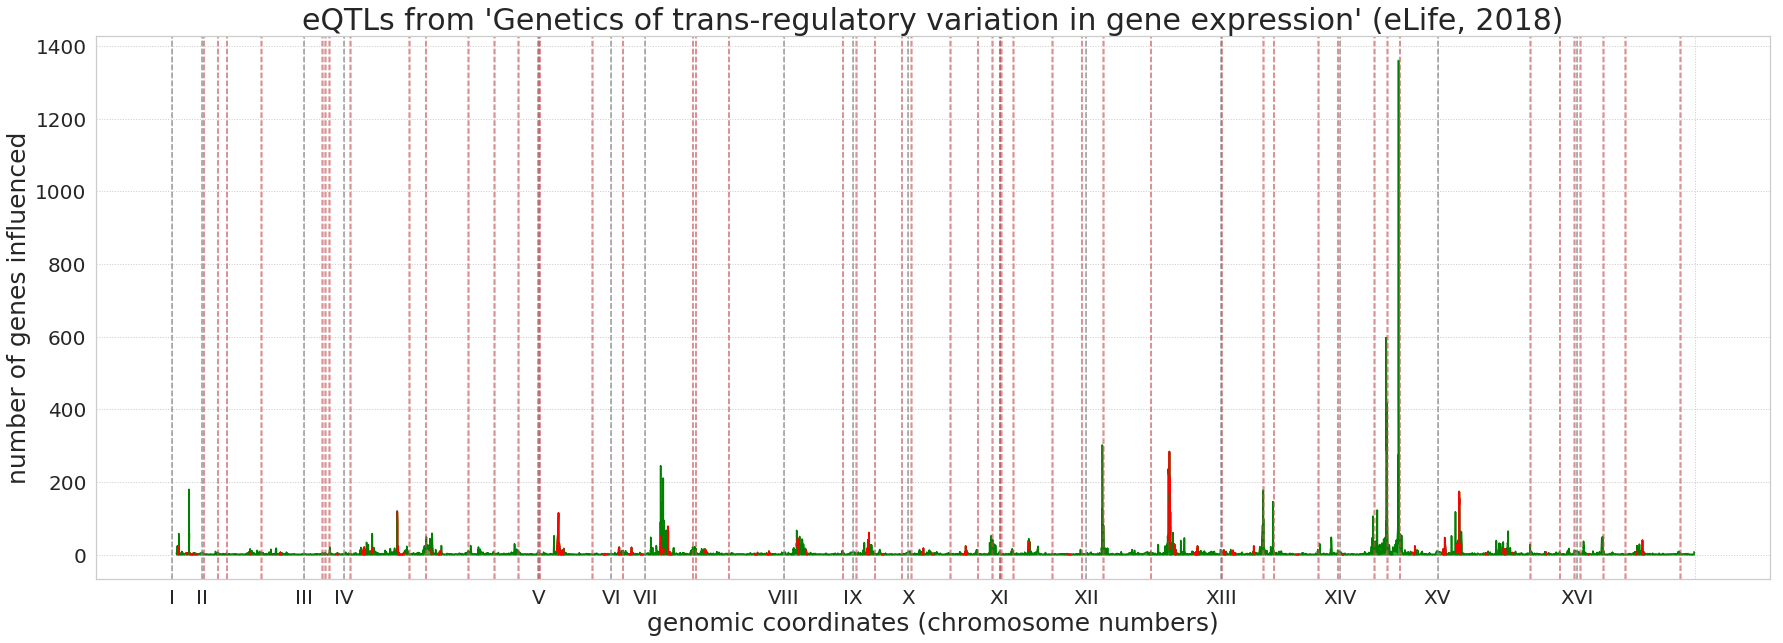

In [257]:
plotter = HotspotPlotter(figsize=(30,10), 
                         qtl_df=qtls_df["eQTLs_2018"]["A&B"], 
                         qtl_type="eQTLs_2018", 
                         title="eQTLs from 'Genetics of trans-regulatory variation in gene expression' (eLife, 2018)")
ax = plotter.ax
hotspot_intervals = []
for chr_name, l, r in hotspot_df[["chromosome", "bootstrapIntervalLeft", "bootstrapIntervalRight"]].values:
    offset = plotter.chromosome_endpoints[util.as_arabic(chr_name[3:])-1]
    if offset is None: pass
    hotspot_intervals.append([l + offset, r + offset])
hotspot_intervals = np.vstack(hotspot_intervals)
plotter.distplot(hotspot_intervals)

In [236]:
qtls_df["eQTLs_2018"]["A&B"].head()

,gene,SNP,r,LOD,CI.l,CI.r,markerPlotCoordinate,genePlotCoordinate,gene.to.CI.dist,cis,chr,var.exp,lm.coeff,score,CI.lpos,CI.rpos
0,YAL062W,chrI:33293_A/T,-0.780048,206.064062,chrI:33040_A/G,chrI:34170_T/A,33293,31567,0.0,1,chrI,0.574708,-0.765508,0.637525,33040.0,34170.0
1,YAL060W,chrI:35818_A/G,0.606570,100.811735,chrI:35128_AG/A,chrI:36637_A/G,35818,35155,0.0,1,chrI,0.322080,0.569702,0.824874,35128.0,36637.0
2,YAL056W,chrI:39162_C/G,-0.819592,244.787267,chrI:39162_C/G,chrI:39162_C/G,39162,39259,0.0,1,chrI,0.656611,-0.811306,0.568598,39162.0,39162.0
3,YAL055W,chrI:43691_C/T,-0.299326,20.627539,chrI:36313_A/G,chrI:47044_A/C,43691,42177,0.0,1,chrI,0.082008,-0.285988,0.967602,36313.0,47044.0
4,YAL054C,chrI:44384_A/G,-0.408248,40.065619,chrI:42115_T/C,chrI:48815_T/C,44384,42881,0.0,1,chrI,0.149331,-0.375047,0.933003,42115.0,48815.0


In [237]:
qtls_df["eQTLs_2018"]["A&B"].tail()

,gene,SNP,r,LOD,CI.l,CI.r,markerPlotCoordinate,genePlotCoordinate,gene.to.CI.dist,cis,chr,var.exp,lm.coeff,score,CI.lpos,CI.rpos
36493,YPR192W,chrXVI:84945_G/A,-0.151521,5.104068,chrXVI:36977_C/T,chrXVI:85843_A/G,11208205,12045120,835016.0,0,chrXVI,0.005378,-0.073838,0.995234,11009783.0,11058649.0
36494,YPR202W,chrXVI:36977_C/T,0.165498,6.102922,chrXVI:26510_T/C,chrXVI:40552_T/C,11160237,12066292,901479.0,0,chrXVI,0.017047,0.130975,0.993456,10999316.0,11013358.0
36495,YPR204W,chrXVI:29604_CA/C,-0.270060,16.641657,chrXVI:26510_T/C,chrXVI:40490_A/G,11152864,12067863,905211.0,0,chrXVI,0.034619,-0.186466,0.974697,10999316.0,11013296.0
36496,YJL158C,chrXVI:286882_C/CA,0.167071,6.221107,chrXVI:261137_C/G,chrXVI:299678_G/T,11410142,5954726,NaN,0,chrXVI,0.019055,0.140393,0.993246,11233943.0,11272484.0
36497,YKR013W,chrXVI:210433_A/G,0.156892,5.476902,chrXVI:199138_T/C,chrXVI:215973_C/T,11333693,7042171,NaN,0,chrXVI,0.010439,0.105866,0.994570,11171944.0,11188779.0


In [238]:
chromosome_endpoints = plotter.chromosome_endpoints
def marker_to_coord(marker):
    chr_name, rest = marker.split(":")
    offset = int(rest.split("_")[0])
    return offset + chromosome_endpoints[util.as_arabic(chr_name[3:]) - 1]

qtls_df["eQTLs_2018"]["A&B"]["CI.lpos"] = qtls_df["eQTLs_2018"]["A&B"]["CI.l"].apply(marker_to_coord)
qtls_df["eQTLs_2018"]["A&B"]["CI.rpos"] = qtls_df["eQTLs_2018"]["A&B"]["CI.r"].apply(marker_to_coord)

In [261]:
simulation_results = []
interactome = "physical"
df = qtls_df["eQTLs_2018"]["A&B"]
pts = []
for l, r in tqdm_notebook(hotspot_intervals, "hotspot"):
    hotspot_qtls_df = df[df["CI.rpos"].apply(lambda x: min(x, r)) 
                         - df["CI.lpos"].apply(lambda x: max(x, l)) >= 0]
    if hotspot_qtls_df.shape[0] == 0: 
        simulation_results.append([])
        continue
    pts.append([(l + r) / 2, hotspot_qtls_df.shape[0]])    
    rptest = qtls.RandomizedInteractomeTest(
        type2interactome["physical"], 
        "physical",
        hotspot_qtls_df,
        np.atleast_1d(1.),
        "data/raw/randomized_interactome_copies/",
        max_iter=128, 
        n_jobs=1
    )
    simulation_results.append(rptest.map_reduce())
    print(simulation_results.append[-1])

pts = sorted(pts, key=lambda p:p[0])
pts = np.vstack(pts)
plt.figure(figsize=(16,8))
plt.stem(pts[:, 0], pts[:, 1]);
plt.yticks([0, 1000, 2000, 3000, 4000])
plt.xticks(chromosome_endpoints, [util.as_roman(n) for n in range(1, 17)]);

n_iters:  27%|██▋       | 34/128 [00:17<00:49,  1.89it/s]

KeyboardInterrupt: 